In [1]:
import os

import geopandas
import intake
import ipywidgets
import matplotlib.pyplot as plt
import numpy
import pandas
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.utils

import laplan

cat = intake.open_catalog("../catalogs/*.yml")

In [2]:
parcel_to_tract = cat.crosswalk_parcels_tracts.read()

In [3]:
# ACS data for income, race, commute, tenure
census = cat.census_analysis_table.read()

In [4]:
# Census tracts
tracts = cat.census_tracts.read()

In [5]:
prefix_list = laplan.pcts.VALID_PCTS_PREFIX
suffix_list = laplan.pcts.VALID_PCTS_SUFFIX

remove_prefix = ["ENV"]
remove_suffix = [
    "EIR",
    "IPRO",
    "CA",
    "CATEX",
    "CPIO",
    "CPU",
    "CRA"
    "FH",
    "G",
    "HD",
    "HPOZ",
    "ICO",
    "K",
    "LCP",
    "NSO",
    "RFA",
    "S",
    "SN",
    "SP",
    "ZAI",
]

prefix_list = [x for x in prefix_list if x not in remove_prefix]
suffix_list = [x for x in suffix_list if x not in remove_suffix]

In [6]:
# Load PCTS and subset to the prefix / suffix list we want
pcts = cat.pcts2.read()
pcts = laplan.pcts.subset_pcts(
    pcts,
    prefix_list=prefix_list,
    suffix_list=suffix_list,
    get_dummies=True,
    verbose=True,
)
pcts = laplan.pcts.drop_child_cases(pcts, keep_child_entitlements=True)

Parsing PCTS case numbers
2146 cases failed to parse.
Getting dummy indicators for case types
Prefixes with no associated cases:  {'VTT', 'TT', 'PS', 'HPO'}
Suffixes with no associated cases:  {'REC4', 'SUP1', 'SCPE', 'PA', 'REC3', 'REC5', 'REC2', 'SE', 'ADD1', 'EAF', 'ND', 'SUD', 'SCEA'}


In [7]:
# Associate each PCTS entitlement case with a census tract:
pcts = pcts.merge(
    parcel_to_tract[["GEOID", "AIN"]],
    how="inner",
    on="AIN",
)

In [8]:
big_cases = pcts.CASE_ID.value_counts()
big_cases = big_cases[big_cases > 20]
pcts = pcts[~pcts.CASE_ID.isin(big_cases.index)]

In [9]:
entitlement_counts = (pcts
    [["GEOID", "CASE_ID", "CASE_YR_NBR"] + suffix_list]
    .astype({c: "int64" for c in suffix_list})
    .dropna(subset=["GEOID"])
    .groupby("CASE_ID").agg({
        **{s: "max" for s in suffix_list},
        "CASE_YR_NBR": "first",
        "GEOID": "first", # in the interests of speed, grab first instead of mode
    })
    .groupby(["GEOID", "CASE_YR_NBR"])
    .sum()
).reset_index(level=1).rename(columns={"CASE_YR_NBR": "year"})

entitlement_counts = entitlement_counts.assign(
    year=entitlement_counts.year.astype("int64")
)

In [10]:
entitlement_counts

,year,TOC,WDI,WTM,CPIOC,OVR,MPC,REC1,EXT,P,...,EAF,CPIOA,CE,DA,PPSP,M11,M10,DEM,ADD1,CASP
GEOID,,,,,,,,,,,,,,,,,,,,,
06037101110,2012,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06037101110,2013,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06037101110,2014,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
06037101110,2017,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06037101122,2013,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06037980028,2015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06037980028,2016,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06037980028,2018,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
start_year = 2010
end_year = 2019

year_condition = entitlement_counts.year > start_year

entitlement_subset = entitlement_counts[year_condition]
include_entitlements = (
    entitlement_subset[suffix_list]
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .index
)
include_entitlements

Index(['CWC', 'CUB', 'SPP', 'CEX', 'TOC', 'OVR', 'CWNC', 'ZV', 'ZAA', 'VSO',
       'CU', 'MSP', 'DRB', 'CDP', 'MEL', 'ADU', 'MA', 'SPR', 'PMLA', 'CPIOC',
       'UDU', 'DB', 'ZAD', 'CUW', 'CDO', 'COA', 'HCM', 'PMEX', 'F', 'CM'],
      dtype='object')

In [12]:
entitlements = (
    entitlement_subset
    [list(include_entitlements)]
    .groupby(entitlement_subset.index)
    .sum()
)
entitlements

,CWC,CUB,SPP,CEX,TOC,OVR,CWNC,ZV,ZAA,VSO,...,UDU,DB,ZAD,CUW,CDO,COA,HCM,PMEX,F,CM
GEOID,,,,,,,,,,,,,,,,,,,,,
06037101110,0,0,1,0,0,0,0,2,3,0,...,0,0,0,2,0,0,0,0,0,0
06037101122,0,0,3,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06037101210,0,2,14,0,0,9,0,1,1,0,...,0,4,0,0,0,0,0,0,0,0
06037101220,0,0,2,0,0,5,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
06037101300,0,2,4,0,0,6,0,0,2,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06037980014,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06037980015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06037980019,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Merge census data with entitlements counts.
# We also bring in census geometries and the number of parcels
# in a given tract.
joined = pandas.merge(
    census.dropna().set_index("GEOID"),
    entitlements,
    how="left",
    left_index=True,
    right_index=True,
).fillna(0).reset_index().merge(
    tracts[["GEOID10", "geometry"]],
    how="left",
    left_on="GEOID",
    right_on="GEOID10",
).drop(columns="GEOID10").set_index("GEOID").dropna().assign(
    n_parcels=parcel_to_tract.groupby("GEOID").size()
)
joined

,non_car_workers,workers_total,pct_non_car_workers,zero_veh_workers,pct_zero_veh_workers,pop_renter,pop_total,pct_pop_renter,pop_whitenonhisp,pct_whitenonhisp,...,ZAD,CUW,CDO,COA,HCM,PMEX,F,CM,geometry,n_parcels
GEOID,,,,,,,,,,,,,,,,,,,,,
06037101110,46,1927,0.023871,0,0.000000,2199,4219,0.521214,2516,0.583217,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6471651.068 1918306.964, 64719...",1199.0
06037101122,11,1907,0.005768,8,0.004195,577,3234,0.178417,2755,0.850571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6477840.844 1917081.399, 64778...",1316.0
06037101210,171,2770,0.061733,114,0.041155,5247,5987,0.876399,2991,0.494217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6475267.737 1915630.020, 64752...",838.0
06037101220,54,1513,0.035691,54,0.035691,2110,3497,0.603374,1694,0.484415,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,"MULTIPOLYGON (((6477611.571 1915577.225, 64775...",721.0
06037101300,86,2041,0.042136,10,0.004900,353,4250,0.083059,3503,0.815220,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"MULTIPOLYGON (((6481507.143 1914335.333, 64815...",1519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06037930200,18,167,0.107784,0,0.000000,94,386,0.243523,271,0.646778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6434869.547 1942437.807, 64350...",NaN
06037980015,14,289,0.048443,9,0.031142,525,525,1.000000,84,0.151079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6467779.957 1740632.011, 64685...",8.0
06037980019,0,76,0.000000,0,0.000000,25,151,0.165563,125,0.827815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6388919.695 1848109.430, 63889...",53.0


<AxesSubplot:>

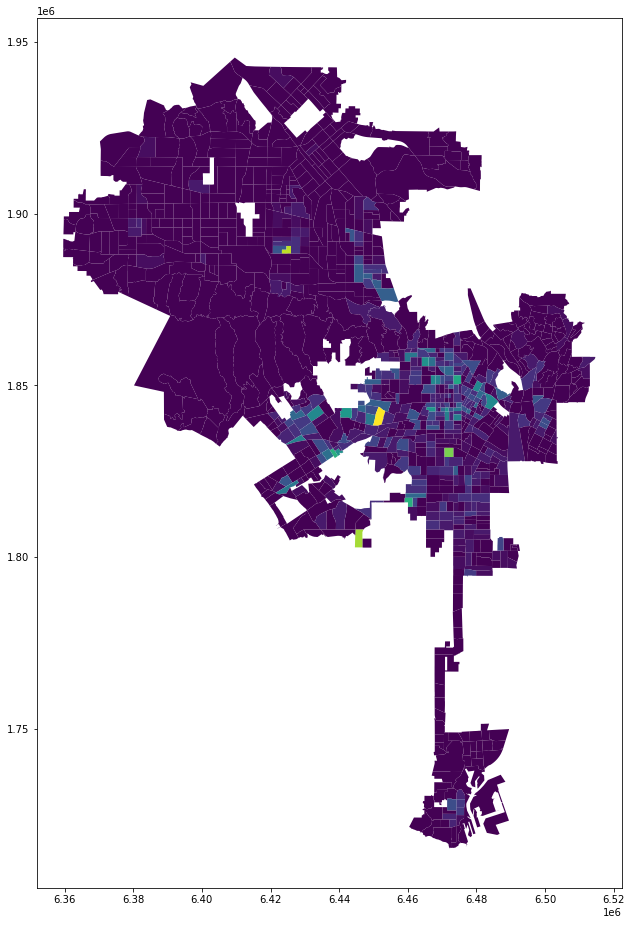

In [14]:
column = "TOC"
geopandas.GeoDataFrame(
    joined.assign(**{column: joined[column]}).dropna(), geometry="geometry"
).plot(figsize=(16,16), column=column)

In [15]:
cols=[
    "medhhincome",
    "pct_pop_renter",
    "pct_zero_veh_workers",
    "density",
    "pct_whitenonhisp"
]

In [16]:
model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.linear_model.PoissonRegressor(fit_intercept=True, tol=1.e-6))
])

In [17]:
rs = numpy.random.RandomState(1)

def fit_model(variables, target, norm=1, samples=100): 
    def get_coefs(model):
        return model["regressor"].coef_

    samples = numpy.array([
        get_coefs(model.fit(*sklearn.utils.resample(
            variables,
            (target/norm).replace([numpy.nan, numpy.inf], 0.0),
            random_state=rs,
        )))
        for i in range(samples)
    ])
    return samples

Fitting model for CWC
Fitting model for CUB
Fitting model for SPP
Fitting model for CEX
Fitting model for TOC
Fitting model for OVR
Fitting model for CWNC
Fitting model for ZV
Fitting model for ZAA
Fitting model for VSO
Fitting model for CU
Fitting model for MSP
Fitting model for DRB
Fitting model for CDP
Fitting model for MEL
Fitting model for ADU
Fitting model for MA
Fitting model for SPR
Fitting model for PMLA
Fitting model for CPIOC
Fitting model for UDU
Fitting model for DB
Fitting model for ZAD
Fitting model for CUW
Fitting model for CDO
Fitting model for COA
Fitting model for HCM
Fitting model for PMEX
Fitting model for F
Fitting model for CM


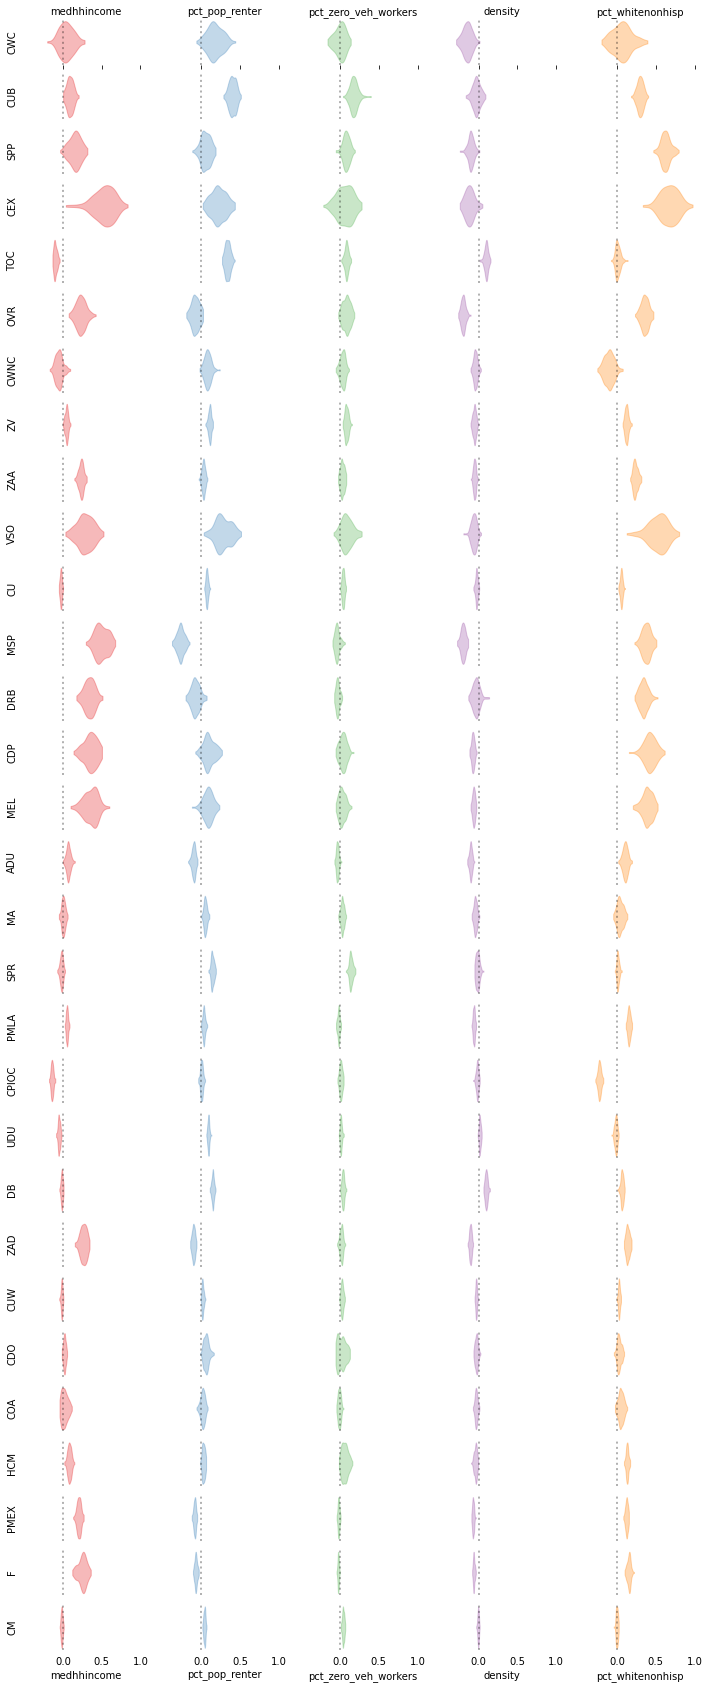

In [18]:
inc = include_entitlements

fig, axes = plt.subplots(
    len(inc),
    len(cols),
    sharex=True,
    sharey=True,
    figsize=(12, 1*len(inc)),
)

colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]

for i, ent in enumerate(inc):
    print(f"Fitting model for {ent}")
    samples = fit_model(joined[cols], joined[ent], norm=1, samples=100)
    for j, var in enumerate(cols):
        ax = axes[i, j]

        # Add a zero line
        ax.axvline(0, linewidth=2, alpha=0.3, color="k", linestyle="dotted")
        #ax.set_ylim(-0.5, 0.5)
        
        # Remove a lot of unnecessary labels and ticks on the subplots
        ax.tick_params(which="both", right=False, left=False)
        ax.set_yticklabels([])     
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)

        if j == 0:
            ax.set_ylabel(ent)
        if i == 0:
            ax.set_xlabel(var)
            ax.xaxis.set_label_position("top")
        elif i == len(inc)-1:
            ax.set_xlabel(var)
            ax.xaxis.set_label_position("bottom")
            ax.tick_params(which="both", bottom=False)
        else:
            ax.tick_params(which="both", bottom=False)

        parts = ax.violinplot(samples[:, j], vert=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_color(colors[j])

fig.show()

In [19]:
fig.savefig("entitlements.png", bbox_inches="tight", dpi=300)

In [20]:
def plot_model(variables, target, norm=1):
    t = (target/norm).replace([numpy.nan, numpy.inf], 0.0)
    model.fit(variables, t)
    fig, axes = plt.subplots(1, len(variables.columns), figsize=(12, 3))
    for i, var in enumerate(variables.columns):
        ax = axes[i]
        ax.scatter(variables[var], target)
        #ax.scatter(variables[var], model.predict(variables))
        ax.set_xlabel(var)
        if i == 0:
            ax.set_ylabel("Count")
    plt.close(fig) # prevent double plotting
    return fig

In [21]:
def plot_map(variables, target, norm=1):
    t = (target/norm).replace([numpy.nan, numpy.inf], 0.0)
    model.fit(variables, t)
    gdf = geopandas.GeoDataFrame(
        joined.assign(
            predict=model.predict(variables),
            target=t,
        )
    )
    vmax = gdf.target.max()
    vmin = gdf.target.min()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    gdf.plot(column="target", cmap="plasma", ax=ax[0])
    gdf.plot(column="predict", cmap="plasma", ax=ax[1])
    ax[0].axis("off")
    ax[1].axis("off")
    ax[0].set_title(f"Number of {target.name}")
    ax[1].set_title(f"Predicted number of {target.name}")
    plt.close(fig)
    return fig

In [22]:
output = ipywidgets.Output()
dropdown = ipywidgets.Dropdown(options=inc)
#norm = joined.pop_total
norm = 1
def on_selection(*args):
    with output:
        output.clear_output(wait=True)
        display(
            plot_map(joined[cols], joined[dropdown.value], norm),
            plot_model(joined[cols], joined[dropdown.value], norm)
        )
dropdown.observe(on_selection, names=["value"])

on_selection()
display(dropdown, output)

Dropdown(options=('CWC', 'CUB', 'SPP', 'CEX', 'TOC', 'OVR', 'CWNC', 'ZV', 'ZAA', 'VSO', 'CU', 'MSP', 'DRB', 'C…

Output()